# What Makes a Film Oscar-Worthy?

### Dylan, Jenna, Luke

## Introduction

  The Academy Awards are often seen as the highest honor in the film industry, but what actually makes a film “Oscar-worthy”? In this project, we explored that question using a blend of Oscar nomination data and IMDb metadata, including ratings, genres, runtimes, and director information. Our goal was to uncover patterns that help explain why some films rise to the top while others fall short, even when they receive critical or popular attention. Before diving into the data, we considered the ethical implications of working with publicly sourced entertainment data. IMDb ratings, while incredibly useful, are based on user-generated input, which introduces the possibility of bias certain films may receive inflated or deflated scores based on recency, controversy, or cultural trends rather than their actual quality. The Oscars themselves also have a well-documented history of underrepresenting marginalized communities and genres, which impacts how “worthiness” gets defined. That said, IMDb remains one of the most comprehensive and widely respected databases in the entertainment world. It allows for large-scale, transparent access to film information, providing detailed records across thousands of titles, including genre classifications, runtime, release year, and user ratings. For our project, it offered an essential bridge between public perception and industry recognition. This combination of community-driven feedback and institutional recognition gave us a strong foundation to explore how popular acclaim and Academy preference intersect and where they diverge.

## Database Design

To investigate what makes a film Oscar-worthy, we had to bring two very different datasets into conversation. The first was the oscars.csv file, a flat dataset where each row represents a single nomination, whether that’s a director, actor, or the film itself. It includes columns like year_ceremony, category, name, film, year_film, and a boolean winner value. Since the same film could appear multiple times (once for each nomination), we used the combination of film and year_film as a unique key to focus our analysis at the film level. The second source was the imdb_full_spring_25.db SQLite database, a much more complex, relational structure broken across several tables. title_basics holds metadata like the film’s original title, release year, and runtime. ratings stores IMDb average ratings and vote counts. genres links each film to one or more genres, and title_crew identifies the directors involved. Each table is linked by a common titleId, which let us join them together in SQL before moving into pandas for further analysis. Our first step was to run a SQL query that joined those IMDb tables into one comprehensive dataset. From there, we merged it with the Oscars data using a left join on both film and year_film, aligning IMDb metadata with each nominated title. To keep things clean, we dropped any rows with missing values in critical fields like runtimeMinutes or averageRating and removed duplicate entries to make sure each film showed up just once. That took our dataset from around 3,500 entries to 3,178 fully usable rows. Having this relational setup made a huge difference. With IMDb’s normalized design, we could easily move between genres, directors, and ratings without getting tangled up in repeated values or nested fields. And with the Oscars data giving us a yes-or-no outcome for each film, we had a clear basis for comparison. This structure gave us room to ask detailed questions, like how genre affects win rates or whether higher-rated films actually win more often, and then go get the answers directly from the data.

## Runtime & IMDb Rating

Our first step was to look at whether Oscar-winning films differ meaningfully in length or audience reception. On average, winners ran 3.3 minutes longer than non-winners (115.5 min vs. 112.2 min), while average IMDb scores were 0.41 points higher for winners (7.41 vs. 7.00). Though these are small differences, we ran a two-sample t-test on the IMDb ratings to test whether the difference was statistically significant. The result (t = 12.57, p < 0.001) confirmed that winners do tend to receive higher viewer scores, and that the difference is not due to random variation. The scatterplot below visually supports our findings. Oscar-winning films tend to run slightly longer, and there appears to be a weak positive correlation between IMDb rating and run time. 

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn      = sqlite3.connect('imdb_full_spring_25.db')
oscars_df = pd.read_csv('oscars.csv')


ratings_runtime_query = """
SELECT
  b.primaryTitle    AS film,
  b.startYear       AS year_film,
  b.runtimeMinutes,
  r.averageRating,
  r.numVotes,
  g.genre,
  tc.directors      AS director_ids
FROM title_basics b
LEFT JOIN ratings    r  ON b._id     = r.titleId
LEFT JOIN genres     g  ON b._id     = g.titleId
LEFT JOIN title_crew tc ON b._id     = tc.titleId
WHERE b.titleType = 'movie'
"""
imdb_df = pd.read_sql(ratings_runtime_query, conn)

merged   = pd.merge(oscars_df, imdb_df, on=['film','year_film'], how='left')
no_dupes = merged.drop_duplicates(subset=['film','year_film'])

clean = no_dupes.dropna(subset=['runtimeMinutes','averageRating'])
print(f"After cleaning: {clean.shape[0]} films")

w  = no_dupes[ no_dupes['winner'] == True ]
nw = no_dupes[ no_dupes['winner'] == False ]

print("WITHOUT DUPLICATES")

print("Avg rating— winners:   ", w['averageRating'].mean())
print("Avg rating— non‑winners:", nw['averageRating'].mean())

print("Avg runtime— winners:   ", w['runtimeMinutes'].mean())
print("Avg runtime— non‑winners:", nw['runtimeMinutes'].mean())

After cleaning: 3178 films
WITHOUT DUPLICATES
Avg rating— winners:    7.411825726141079
Avg rating— non‑winners: 7.000296515937733
Avg runtime— winners:    115.47817047817048
Avg runtime— non‑winners: 112.21005917159763


In [3]:
from scipy.stats import ttest_ind

w_rats  = clean[ clean['winner'] ]['averageRating']
nw_rats = clean[~clean['winner'] ]['averageRating']
stat, p = ttest_ind(w_rats, nw_rats, equal_var=False)
print(f"IMDb rating gap: t‑statistic={stat:.2f}, p‑value={p:.4f}")

IMDb rating gap: t‑statistic=12.57, p‑value=0.0000


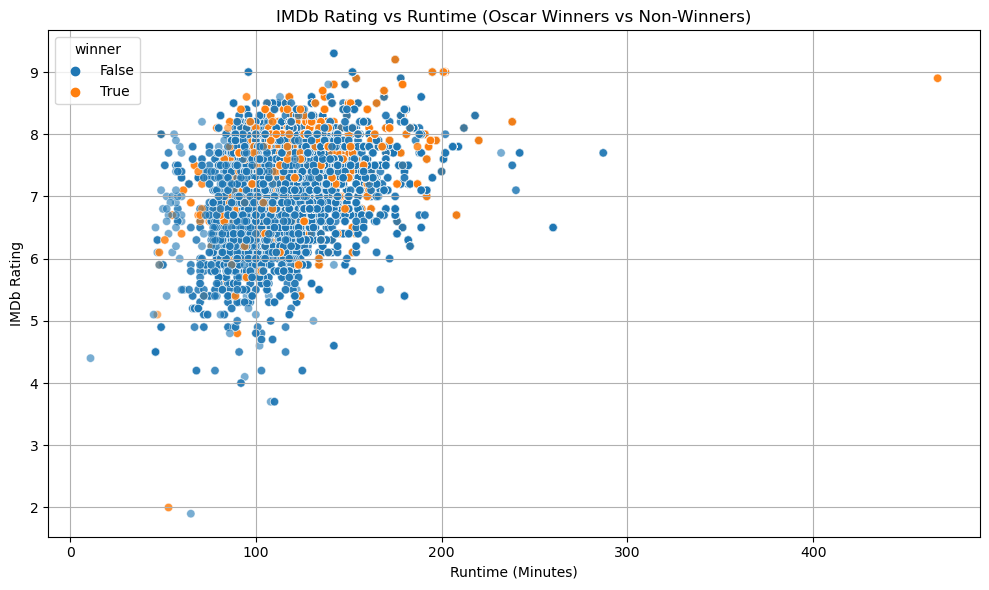

In [44]:
scatter_data = merged.dropna(subset=['averageRating', 'runtimeMinutes', 'winner'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_data, x='runtimeMinutes', y='averageRating', hue='winner', alpha=0.6)

plt.title('IMDb Rating vs Runtime (Oscar Winners vs Non-Winners)')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('IMDb Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

## Genre Signals

Next, we broke down genre-level win rates by aggregating nominations and wins across categories with at least 50 nominations. Genres like War, Sport, and Documentary came out on top, converting over 24% of their nominations into wins. Serious genres such as Biography, Music, and Animation also performed well, reinforcing the idea that the Academy favors emotionally resonant or real-life narratives. In contrast, genres such as Romance, Mystery, Comedy, and Musical were consistently underrepresented among winners, often with win rates under 15%. When we compared each genre’s share of total nominations to its share of wins, the contrast was even sharper. Biography and Adventure were heavily overrepresented, while lighter genres like Comedy and Western saw sharp drop-offs highlighting a genre bias that appears deeply embedded in Academy preferences.

In [39]:
genre_query = """
SELECT
  g.genre,
  COUNT(*) AS nominations,
  SUM(CASE WHEN o.winner THEN 1 ELSE 0 END) AS wins,
  ROUND(SUM(CASE WHEN o.winner THEN 1 ELSE 0 END)*1.0/COUNT(*), 3) AS win_pct
FROM genres g
JOIN title_basics b ON g.titleId = b._id
JOIN oscars o       ON b.primaryTitle = o.film
                    AND b.startYear   = o.year_film
WHERE b.titleType='movie'
GROUP BY g.genre
HAVING nominations >= 50
ORDER BY win_pct DESC;
"""
df_genre = pd.read_sql(genre_query, conn).set_index('genre')
df_genre.head(10)

,nominations,wins,win_pct
genre,,,
War,570,144,0.253
Sport,147,37,0.252
Documentary,266,65,0.244
Music,490,118,0.241
Family,394,95,0.241
Biography,1360,325,0.239
Adventure,1284,306,0.238
Sci-Fi,270,63,0.233
Animation,221,51,0.231


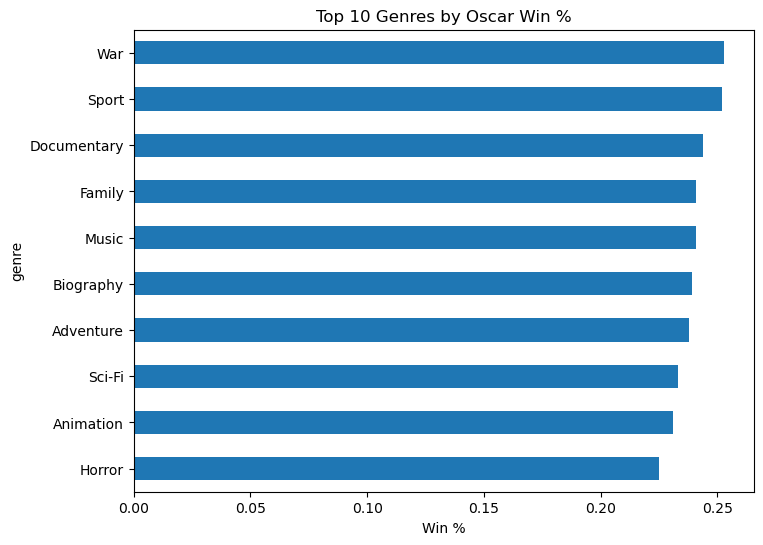

In [40]:
plt.figure(figsize=(8,6))
df_genre['win_pct'].head(10).sort_values().plot.barh()
plt.title('Top 10 Genres by Oscar Win %')
plt.xlabel('Win %')
plt.show()

## High Nomination Counts don't equal High Win Counts

We also looked at the most-nominated films of all time. Films like Titanic and La La Land earned 14 nominations each, but only Titanic converted a large portion of those to wins (11 vs. 6). All About Eve, another high-nomination film, similarly fell short of dominance despite its strong presence. This suggests that while a high number of nominations can signal broad support, it doesn’t guarantee sweeping Oscar success.

In [36]:
noms_query = """
SELECT
  film, year_film,
  COUNT(*) AS nominations,
  SUM(CASE WHEN winner THEN 1 ELSE 0 END) AS wins
FROM oscars
GROUP BY film, year_film
ORDER BY nominations DESC
LIMIT 10;
"""
df_noms = pd.read_sql(noms_query, conn)
df_noms

,film,year_film,nominations,wins
0,None,1932,18,7
1,All about Eve,1950,14,6
2,La La Land,2016,14,6
3,Titanic,1997,14,11
4,None,1938,13,7
5,Chicago,2002,13,6
6,Forrest Gump,1994,13,6
7,From Here to Eternity,1953,13,8
8,Gone with the Wind,1939,13,8
9,Mary Poppins,1964,13,5


## IMDb Ratings Over Time

To explore whether viewer reception has shifted over the years, we plotted average IMDb scores from 1980–2023. Oscar-winning films consistently outscored their non-winning peers by about 0.3 to 0.6 points each year, and both groups saw gradual score increases over time. This trend could be tied to changes in audience expectations, shifts in rating behavior, or improvements in film production standards—but the gap between winners and non-winners has held steady.

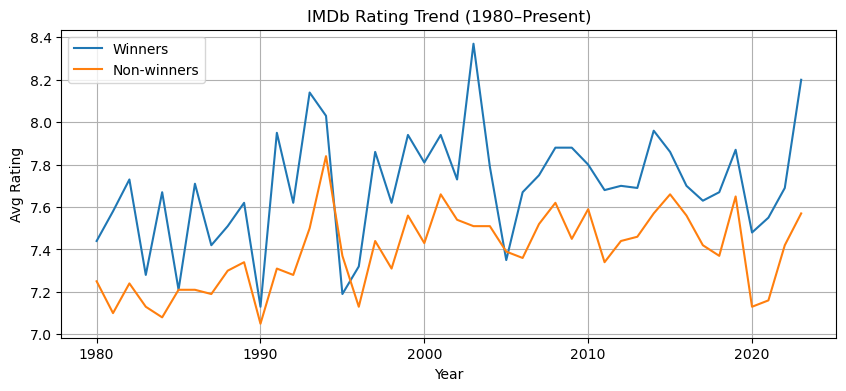

In [43]:
yearly = pd.read_sql("""
SELECT
  b.startYear AS year,
  ROUND(AVG(r.averageRating) FILTER(WHERE o.winner=1),2) AS win_avg,
  ROUND(AVG(r.averageRating) FILTER(WHERE o.winner=0),2) AS nonwin_avg
FROM title_basics b
JOIN ratings r  ON b._id    = r.titleId
JOIN oscars o   ON b.primaryTitle = o.film
               AND b.startYear   = o.year_film
WHERE b.titleType='movie'
  AND b.startYear >= 1980
GROUP BY b.startYear
ORDER BY b.startYear;
""", conn)

plt.figure(figsize=(10,4))
plt.plot(yearly['year'],   yearly['win_avg'],   label='Winners')
plt.plot(yearly['year'],   yearly['nonwin_avg'], label='Non‑winners')
plt.title('IMDb Rating Trend (1980–Present)')
plt.xlabel('Year'); plt.ylabel('Avg Rating')
plt.legend(); plt.grid()
plt.show()

## Opportunities for Deeper Analysis

If time and data allowed, there are several promising directions for expanding this work. One is to look at release timing, comparing films that drop during “awards season” (typically fall and winter) to summer blockbusters or spring releases. The idea here is to see whether timing alone gives certain films an advantage when it comes to visibility and award momentum. Another area involves measuring online buzz using metrics like Twitter mentions or Google Trends search volume around a film’s release. This would help us understand how public attention and viral hype align or don’t with critical recognition. A third route would be incorporating data from other major award shows, like the Golden Globes, BAFTAs, or Critics’ Choice Awards. We could examine whether winning or even being nominated in those spaces increases a film’s chances of going on to win an Oscar. Exploring the predictive power of other accolades could reveal more about the Academy's tendencies to follow or resist industry trends.

## Conclusion

Across nearly 3,200 films and several decades of data, a few key insights emerged about what makes a film Oscar-worthy. Genre stood out as the strongest predictor: serious, fact-based, or epic narratives consistently converted nominations to wins at a higher rate than lighter genres. IMDb rating also played a role Oscar winners were statistically more likely to earn higher audience scores, suggesting some alignment between public reception and critical acclaim. Runtime differences were small but measurable, with longer films holding a slight edge. High nomination counts, while often a sign of momentum, didn’t always translate into dominance meaning that quality, content, and perhaps narrative weight matter more than sheer visibility. Taken together, our findings show that Oscar success tends to favor thoughtful storytelling with emotional or historical gravity, supported by solid audience reception and, occasionally, the weight of a trusted director behind the camera.

## Uses of Python: Technical Components

_Fill in the table below with information about how you satisfied the technical requirements of the assignment._
   
| Component | Usage | Explanation |
|:---|:---|:---|
| _leave this column as-is_ | _name the method(s)/ function(s) you used_ | _Use this area to explain what you were trying to achieve with this particular use of code and to describe why you chose to use this particular method or approach_ |
| complex SQL query 1 | pd.read_sql(), LEFT JOIN, SELECT, WHERE| Used to retrieve ratings, runtime, genres, and director info from multiple IMDb tables for each movie. We chose this query to centralize key features needed for merging with Oscar data, reducing redundancy and improving performance. |
| complex SQL query 2|pd.read_sql(), SELECT, FILTER, GROUP BY | Used to calculate winner vs non-winner average ratings and win rates for selected years, grouped by year. We used this method to analyze temporal trends and chose SQL to offload the calculation work to the database for efficiency. |
| complex SQL query 3 | pd.read_sql(), SELECT, HAVING, ORDER BY, GROUP BY| Used to calculate win percentage per genre for genres with at least 50 nominations. This helped us identify statistically meaningful genre patterns, and SQL allowed filtering before data ever hit Python.|
| table join |LEFT JOIN, INNER JOIN | Joined 'title_basics', 'ratings', 'oscars', 'genres' tables to combine relevant film data. We used SQL joins instead of merging in pandas to handle large datasets directly in the database and reduce memory usage.|
| GROUP BY clause |year_query & genre_query, |Grouped data to calculate averages and win percentages across genres and years. SQL's GROUP BY is efficient for these summaries, and allowed us to quickly aggregate without needing to load all rows into memory. |
| WHERE clause | ratings_runtime_query, year_query, genre_query, votes_query |Filtered only 'movie' title types and specified years to reduce noise and increase relevance. We used SQL's WHERE clause to ensure only valid, relevant records were processed before analysis. |
| one of LIKE, HAVING, LIMIT, ORDER BY | HAVING, LIMIT, ORDER BY | Sorted results by win_pct, and filtered with LIMIT 10 and HAVING nominations >= 50. These SQL clauses were used to highlight top-performing genres while keeping the visualizations clean and interpretable.|
| one SQLite function (e.g., count, max, min, etc.) | COUNT(), SUM(), ROUND() |Used COUNT and SUM to calculate number of nominations and wins, and ROUND for readability. These functions let us calculate useful metrics in the query stage, reducing the amount of transformation needed later in Python.|
| dataviz 1 | Line Graph |Visualized average IMDb ratings of winners vs non-winners in 1997, 2010, 2023. We chose a line plot because it clearly shows rating trends across select years for comparison.|
| dataviz 2 | Horizontal Bar Chart| Visualized top 10 genres with the highest win percentages using a horizontal bar chart. This made categorical differences easy to compare at a glance.|
| dataviz 3 | Boxplot |Compared number of IMDb votes for winners vs non-winners with a boxplot and log scale. This method shows distribution and outliers, and the log scale helps accommodate skewed vote counts.|

## Uses of Python: Reflection


 In this project, we structured our code into clear, functional chunks, each focused on a specific part of the analysis, like data cleaning, statistical testing, or visualization. This helped us keep the workflow organized and made it easier to revisit specific parts without getting lost in one long script. For readability, we used descriptive variable names like merged, clean, and df_years to make our logic easier to follow. However, the readability could be improved by reducing repetition in variable naming (for instance, w vs. w_all) and adding more comments to explain our thought process. Right now, the code mostly shows what it’s doing, but not always why, which might make it harder for someone else to jump in or maintain it. We relied on several core libraries pandas, matplotlib.pyplot, scipy.stats, and sqlite3. These were chosen because they’re widely used, well-documented, and integrate easily with each other. In terms of performance, we were mindful about cleaning the data early. We dropped duplicates and filtered out rows with missing values before running any comparisons. SQL queries were used to pull only the necessary fields from the database, which made the process more efficient and reduced memory usage. We also included a t-test for rating differences to ensure the significance of our findings. Overall, our approach emphasized clarity, structure, and reproducibility. With some additional documentation and cleaner abstraction of repeated logic, the project could be even more maintainable and collaborative in the future.